In [1]:
#imported libraries
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt

In [2]:
#Set thresholds and paths
CONFIDENCE = 0.5  #threshold probability for a label
SCORE_THRESHOLD = 0.5  #a threshold used to filter boxes by score.
IOU_THRESHOLD = 0.5  #threshold intersection value for multiple bounding boxes
config_path = "C:/Users/HP/Downloads/Kaggle/Helmet/yolov3-helmet.cfg" # configuration file which contains information about layers and parameters
weights = "C:/Users/HP/Downloads/Kaggle/Helmet/yolov3-helmet.weights" #contains the weights of yolo pretrained model
#helmet.names contain the labels
labels = open("C:/Users/HP/Downloads/Kaggle/Helmet/helmet.names").read().strip().split("\n")

In [3]:
# load the yolo network
net = cv2.dnn.readNetFromDarknet(config_path, weights)

In [4]:
def model_output(path_name):
    image = cv2.imread(path_name)
    file_name = os.path.basename(path_name)
    filename, ext = file_name.split(".")
    h,w = image.shape[:2] #h is height of image and w is width 
    
    '''
    
    cv2.dnn.blobFromImage function is used for preprocessing required before sending it to dnn model. It does mean_subtraction
    (taking out mu_red, mu_green and mu_blue and subtarcting from each pixel values.) , centre cropping,
     changing it to size we want...here...(416,416)
    Also scaling is done(1/sigma), ...here...1/255.0 is the sacle factor...
    
    '''
    
    blob = cv2.dnn.blobFromImage(image, 1/255.0,(416,416), swapRB = True, crop = False)
    
    net.setInput(blob)  # Sets the new input value for the network
    
    ln = net.getLayerNames()
    ln = [ln[i[0]- 1] for i in net.getUnconnectedOutLayers()]  #ln is a list comprising all layers in config file
    layer_outputs = net.forward(ln) #feed forward and get the layer outputs
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            '''
            detection = [pc, bx, by, bh, bw, c1, c2, c3,.....,cn] where n is number of classes
            pc is probability of object presence
            bx and by are center x and center y coordinate of bounding box ;bh,bw are height and width of box
            c1,c2,..,cn are probability of occuring of particular class.
            scores array stores c1,c2,c3,..cn
            '''
            scores = detection[5:]
            class_id = np.argmax(scores)  #extract the class id (label)
            confidence = scores[class_id] #extract the confidence (as a probability)
            if confidence>CONFIDENCE:
                box = detection[:4]*np.array([w,h,w,h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width/2)) #x is top left x coordinate of box
                y = int(centerY - (height/2)) #y is top left y coordinate of box
                boxes.append([x, y, int(width), int(height)]) 
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids # returned the boxes dimensions, confidences and labels

In [5]:
def detection_recognition(path_name):
    image = cv2.imread(path_name)
    boxes, confidences, class_ids = model_output(path_name)
    '''
    cv2.dnn.NMSBoxes() Perform the non maximum suppression given the scores and thresholds. Non max suppression ensures that an 
    object is not detected multiple times. It looks at the probability of boxes and just keeps one with maximum probability and
    suppresses others. 
    '''
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)
    font_scale = 1
    thickness= 1
    if len(idxs)>0:
        for i in idxs.flatten():
            x, y, w, h = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            
            # draw a bounding box rectangle and label on the image
            cv2.rectangle(image, (x,y), (x+w, y+h), color = (0,0,0), thickness = thickness)
            
            text = f"{labels[class_ids[i]]}:{confidences[i]:.2f}"
            
            # calculate text width & height to draw the transparent boxes as background of the text
            (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale = font_scale, thickness = thickness)[0]
            text_offset_x = x
            text_offset_y = y - 5
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
            overlay = image.copy()
            cv2.rectangle(overlay, box_coords[0], box_coords[1], color = (0,0,0), thickness = cv2.FILLED)
            
            image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)#add 2 copies to one and and the numbers define the blending percent
            
            # now put the text (label: confidence %)
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
    
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

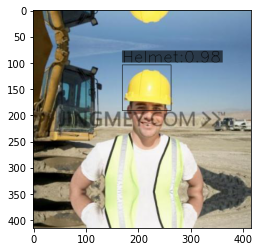

In [6]:
#pass the path of image to detection_recognition function
detection_recognition("E:/datasets/Helmet/hard_hat_workers64.png")